In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from prettytable import PrettyTable
from os import listdir
from sklearn.metrics import f1_score
from datetime import datetime

In [2]:
%run preprocessing.ipynb
%run eval_score.ipynb

In [3]:
mypath = '../../DDC_Data/raw/'
mypathTest = '../../DDC_Data/AMD Patients/'
basepath = '../../'

# Get the Actual Timestamp Labels

In [4]:
def load_timer(subject_id):
    
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if 'history_amdtimer' in f]
    sid_filepath = sid_dir + '/' + sid_files[0]
   
    timer_df = pd.read_csv(sid_filepath, header=None, names=['sid','raw_label', 'timestamp', 'duration','label'])

    filtered_timer = [i for i in timer_df['sid'] if i==int(subject_id)]

    timer_filt = timer_df[timer_df['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)
    
    timer_label = []
    
    for i in range(len(timer_filt)):
        if(timer_filt.loc[i]['raw_label']=='upstairs' or 
          timer_filt.loc[i]['raw_label']=='downstairs'):
            timer_label.append('walk')
        else:
            timer_label.append(timer_filt.loc[i]['raw_label'])

    timer_filt['label'] = pd.Series(timer_label)
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    timer_filt['time_start'] = timer_filt['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))
    
    time_format = '%H:%M:%S'
    zero_date = datetime(1900, 1, 1)
    
    timer_filt['duration'] = timer_filt['duration'].apply(lambda x: datetime.strptime(x, time_format)-zero_date)
    
    for i in range(timer_filt.shape[0]):
        timer_filt.loc[i, 'time_end'] = timer_filt.loc[i, 'time_start'] + timer_filt.loc[i, 'duration']

#     print(timer_filt)
    
    return timer_filt

In [ ]:
def load_timer_2(subject_id):
    
    sid_dir = mypath + subject_id
#     sid_files = [f for f in listdir(sid_dir) if 'history_amdtimer' in f]

    sid_filepath = sid_dir 

    timer_df = pd.read_csv(sid_filepath, header=None, names=['sid','raw_label', 'timestamp', 'duration','label'])

    filtered_timer = [i for i in timer_df['sid'] if i==int(subject_id)]

    timer_filt = timer_df[timer_df['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)
    
    timer_label = []
    
    for i in range(len(timer_filt)):
        if(timer_filt.loc[i]['raw_label']=='upstairs' or 
          timer_filt.loc[i]['raw_label']=='downstairs'):
            timer_label.append('walk')
        else:
            timer_label.append(timer_filt.loc[i]['raw_label'])

    timer_filt['label'] = pd.Series(timer_label)
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    timer_filt['time_start'] = timer_filt['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))
    
    time_format = '%H:%M:%S'
    zero_date = datetime(1900, 1, 1)
    
    timer_filt['duration'] = timer_filt['duration'].apply(lambda x: datetime.strptime(x, time_format)-zero_date)
    
    for i in range(timer_filt.shape[0]):
        timer_filt.loc[i, 'time_end'] = timer_filt.loc[i, 'time_start'] + timer_filt.loc[i, 'duration']

#     print(timer_filt)
    
    return timer_filt

# Load Data of the Subject

In [5]:
def load_acc(subject_id, start_time, end_time):
    # Load accelerations
    acc_path = mypath + '/' + subject_id + '/' + subject_id + '-log_acc.csv'

    df = pd.read_csv(acc_path, header=None, names=['x','y','z','timestamp'])
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))

    filtered = [r for r in df['timestamp'] if r>=start_time and r<=end_time]

    df_filt = df[df['timestamp'].isin(filtered)]
    df_filt = df_filt.reset_index(drop=True)

    df_filt['ID'] = pd.Series([subject_id for i in range(len(df_filt))])
    
    cols = ['ID','timestamp','x','y','z']
    df_filt = df_filt[cols]
    
    xyz_cols = ['x','y','z']
    for c in xyz_cols:
        min_i = df_filt[c].min()
        max_i = df_filt[c].max()
        
        df_filt[c] = df_filt[c].apply(lambda x: (x-min_i)/(max_i-min_i))
        
    return df_filt

In [6]:
def load_data(test_subj, df_sid):
    filepath = mypath + test_subj + '/' + test_subj + '-log_acc.csv'

    df_test = pd.read_csv(filepath, header=None, names=['x','y','z','timestamp'])

    test_filt = [i for i in range(len(df_test)) 
                 if calc_sec(df_test.loc[i]['timestamp'].split(' ')[1])<=calc_sec(df_sid.loc[len(df_sid)-1]['finish']) 
                 and calc_sec(df_test.loc[i]['timestamp'].split(' ')[1])>=calc_sec(df_sid.loc[0]['start'])]

    df_test_filt = df_test[df_test.index.isin(test_filt)]
    df_test = df_test_filt.reset_index(drop=True)
    
    return df_test

# Preprocess (PCA, impure)

In [7]:
def preprocess_data(df_test):
    ts_list = []
    g = 9.8

    X_list = []
    
    for i in range(len(df_test)):
        X_i = [df_test.loc[i]['x']/g, df_test.loc[i]['y']/g, df_test.loc[i]['z']/g]
        X_list.append(X_i)
        
    X_stack = np.vstack(X_list)
    X_norm = MinMaxScaler().fit_transform(X_stack)

    y_imp = [-1 for i in range(X_norm.shape[0])]
    X_imp, y_imp = prepare_impure_label(X_norm, y_imp)
    
    return X_imp, y_imp

# Predict

In [8]:
%run classifier_algo.ipynb

In [9]:
def predict_combine(X_imp, model, window_length=60):
    
    y_pred = model.predict(X_imp)
    print("Finished prediction")
    
#     y_pred = combine_2(X_imp, y_pred)

#     y_pred_fill = np.hstack(([y_pred[0] for i in range(window_length-1)], y_pred))
    
#     print(X_imp.shape, y_pred_fill.shape)
    #y_pred_fill -> y_pred
    return y_pred

# Group dataframe by label

In [10]:
def group_dataframe_by_label(df1, df_timer, subject_id, label_list):
    df_list = {}
    period = {}
    df2 = df1.copy()
    
    for label in label_list:
        df_list[label] = pd.DataFrame()
        period[label] = []
    
    for label in label_list:
#         print(label)
        for i in range(df_timer.shape[0]):
            start = 0
            end = 0
            
            if(df_timer.loc[i, 'label']==label):
                t_a = df_timer.loc[i, 'time_start']
                t_b = df_timer.loc[i, 'time_end']

                for j in range(df1.shape[0]):    
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j>0 and df1.loc[j, 'timestamp']<=t_b and df1.loc[j-1, 'timestamp']<t_b):
                            end = j

                for j in reversed(range(df1.shape[0])):
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j<df1.shape[0]-1 and df1.loc[j, 'timestamp']>=t_a and df1.loc[j+1, 'timestamp']>t_a):
                            start = j
                            
                for j in range(start, end+1):
                    df2.loc[j, 'label'] = label

                period[label].append([start, end])
                
                if(df_list[label].empty):
                    df_list[label] = df1.loc[start:end+1]
                else:
                    df_list[label].append(df1.loc[start:end+1], ignore_index=True)
                    
    for label in label_list:
        df_list[label] = df_list[label].reset_index(drop=True)

    return df_list, df2, period

In [ ]:
def group_dataframe_by_label_test(df1, df_timer, subject_id, label_list):
    df_list = {}
    period = {}
    df2 = df1.copy()
    
    for label in label_list:
        df_list[label] = pd.DataFrame()
        period[label] = []
    
    for label in label_list:
#         print(label)
        for i in range(df_timer.shape[0]):
            start = 0
            end = 0
            
            if(df_timer.loc[i, 'label']==label):
                t_a = df_timer.loc[i, 'time_start']
                t_b = df_timer.loc[i, 'time_end']

                for j in range(df1.shape[0]):    
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j>0 and df1.loc[j, 'timestamp']<=t_b and df1.loc[j-1, 'timestamp']<t_b):
                            end = j

                for j in reversed(range(df1.shape[0])):
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j<df1.shape[0]-1 and df1.loc[j, 'timestamp']>=t_a and df1.loc[j+1, 'timestamp']>t_a):
                            start = j
                            
                for j in range(start, end+1):
                    df2.loc[j, 'label'] = label

                period[label].append([start, end])
                
                if(df_list[label].empty):
                    df_list[label] = df1.loc[start:end+1]
                else:
                    df_list[label].append(df1.loc[start:end+1], ignore_index=True)
                    
    for label in label_list:
        df_list[label] = df_list[label].reset_index(drop=True)

    return df_list, df2, period

In [11]:
def get_others_from_true_periods(true_periods, df_length, label_list):
    actual_labels = [-1 for i in range(df_length)]
    
    for lb, label in enumerate(label_list):
#         print(label)
        for p_i in true_periods[label]:
            start_i = p_i[0]
            end_i = p_i[1]
            
            for i in range(start_i, end_i+1):
                actual_labels[i] = lb
                
    for i, x_i in enumerate(actual_labels):
        if(x_i==-1):
            actual_labels[i] = 4     # 'others'
            
    return actual_labels

# Prepare Predicted Labels

In [12]:
def get_periods_from_list(y_pred, label_list):
    
    pred_periods = [[] for i in range(len(label_list))]

    keep = 0

    for i in range(len(y_pred)):
        keep_lb = y_pred[keep]

        if(keep_lb!=y_pred[i]):
            
            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i-1])               

            keep = i

        elif(i==len(y_pred)-1):

            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i]) 

    pred_periods = np.array(pred_periods)
    
    return pred_periods

In [ ]:
def get_periods_from_list_deep(y_pred, label_list):
    
    pred_periods = [[] for i in range(len(label_list))]

    keep = 0
    ind = 0
    
    for i in range(len(y_pred)):
        a = y_pred[i][0]
        b = y_pred[i][1]
        c = y_pred[i][2]
        d = y_pred[i][3]
        maxx = max(a,max(b,max(c,d)))
        
        for j in range(4):
            if(maxx==y_pred[i][j]):
                ind = j
                break;
                
        
    for i in range(len(y_pred)):
        keep_lb = y_pred[keep]

        if(keep_lb!=y_pred[i]):
            
            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i-1])               

            keep = i

        elif(i==len(y_pred)-1):

            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i]) 

    pred_periods = np.array(pred_periods)
    
    return pred_periods

In [13]:
def postprocess_predicted(pred_periods, y_length):
    onesec = 1.5  # 1 sec.
    T = 0.16    # T = 1/f

    pp_periods = []
    
    for pp in pred_periods:
        pp_i = pred_periods[pp]
        
        temp = []
        for p in pp_i:
            if(p[1]-p[0]>int(onesec*2*(1/T))):
                temp.append([p[0],p[1]])
                
        pp_periods.append(temp)

    pp_periods = np.array(pp_periods)
    
    other_label = -1
    all_run = [other_label for i in range(y_length)]

    for i in range(len(pp_periods)):
        for p in pp_periods[i]:
            for j in range(p[0],p[1]+1):
                all_run[j] = i

    for i in range(len(all_run)-1,0,-1):
        if(all_run[i-1]==other_label):
            all_run[i-1] = all_run[i]

    return all_run

# Get sequence from periods

In [14]:
def sequence_from_periods(periods, label_list):
    
    max_length = 0
    
    for label in label_list:
        if(len(periods[label])>0):
            periods_i = np.hstack(periods[label])
        
            if(max_length<max(periods_i)):
                max_length = max(periods_i)
    
    seq = ['' for i in range(max_length+1)]
    
    for label in label_list:
        for element in periods[label]:
            for i in range(element[0], element[1]+1):
                seq[i] = label
    
    return seq, max_length

# Evaluation with IoU

In [15]:
def evaluate_period(p1, p2, max_length, label_list):
    iou_all = []
    
    for lb in label_list:
        p1_onehot = []
        for i in range(max_length):
            if(p1[i]==lb):
                p1_onehot.append(1)
            else:
                p1_onehot.append(0)
                
        p2_onehot = []
        for i in range(max_length):
            if(p2[i]==lb):
                p2_onehot.append(1)
            else:
                p2_onehot.append(0)
                
        intersection = 0
        union = 0
        
        for i in range(max_length):
            if(p1_onehot[i]==1 and p2_onehot[i]==1):
                intersection += 1
            if(p1_onehot[i]==1 or p2_onehot[i]==1):
                union += 1
                
        iou_lb = intersection/union
        
        iou_all.append(iou_lb)
        
    return iou_all

# Evaluation with F1 score

In [16]:
def get_y_true(df2):
    
    filt = df2['label'].isnull()
    df2_filt = df2[filt].copy()
    idx_null = list(df2_filt.index)
    
    
    for i in idx_null:
        df2.loc[i, 'label'] = 'others'
    
    
    label_dict = {'sit': 0, 'sleep': 1, 'stand': 2, 'walk': 3, 'others':4}
    y_true = list(df2['label'].apply(lambda x: label_dict[x]))
    y_true = np.hstack(y_true)
    
    return y_true[1:], df2

In [17]:
def evaluate_con(y_test, y_pred, LABELS):
    show_conf_matrix(y_test, y_pred, LABELS)
    show_clf_report(y_test, y_pred, LABELS)

# Plot Graph

In [18]:
def plot_highlighted(test_subj, df_test, pred_periods, actual_periods, label_list, other_list):
#     print(other_list)
    ax1 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])

    color_list = {
        'sit': 'indianred',
        'sleep': 'khaki',
        'stand': 'lightgreen',
        'walk': 'skyblue',
        'others': 'lightgray'
    }

    for label in label_list:
        cnt = 0
        for item in pred_periods[label]:
            if(cnt==0):
                ax1.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax1.axvspan(item[0], item[1], color=color_list[label])
            
    ax2 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])
    
    for i, label in enumerate(label_list):
        cnt = 0
        for item in actual_periods[i]:
            if(cnt==0):
                ax2.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax2.axvspan(item[0], item[1], color=color_list[label])
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    
    ax1.set_title('Prediction for ' + test_subj)
    ax2.set_title('Actual for ' + test_subj)
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    
    fig1 = ax1.get_figure()
    fig2 = ax2.get_figure()
    
    plt.show()
    
    graph_path = '{}Graphs/{}/'.format(basepath, test_subj)
    if(not os.path.isdir(graph_path)):
        os.mkdir(graph_path)
    
    fig1.savefig(graph_path + test_subj + '-prediction.png', dpi=200)
    fig2.savefig(graph_path + test_subj + '-actual.png', dpi=200)
    
    plt.close(fig1)
    plt.close(fig2)

In [ ]:
def plot_highlighted_test(test_subj, df_test, pred_periods, label_list):
    ax1 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])

    color_list = {
        'sit': 'indianred',
        'sleep': 'khaki',
        'stand': 'lightgreen',
        'walk': 'skyblue',
        'others': 'lightgray'
    }

    for label in label_list:
        cnt = 0
        for item in pred_periods[label]:
            if(cnt==0):
                ax1.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax1.axvspan(item[0], item[1], color=color_list[label])
            
    
    ax1.legend(loc='upper right')
    
    ax1.set_title('Prediction for ' + test_subj)

    ax1.legend(loc='upper right')
    
    fig1 = ax1.get_figure()
    
    plt.show()
    
#     graph_path = '{}Graphs/{}/'.format(basepath, test_subj)
#     if(not os.path.isdir(graph_path)):
#         os.mkdir(graph_path)
    
#     fig1.savefig(graph_path + test_subj + '-prediction.png', dpi=200)
    
#     plt.close(fig1)

In [ ]:
def plot_highlightedpost(test_subj, df_test, pred_periods,post, actual_periods, label_list, other_list):
#     print(other_list)
    ax1 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])
    ax3 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])

    color_list = {
        'sit': 'indianred',
        'sleep': 'khaki',
        'stand': 'lightgreen',
        'walk': 'skyblue',
        'others': 'lightgray'
    }

    for label in label_list:
        cnt = 0
        for item in pred_periods[label]:
            if(cnt==0):
                ax1.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax1.axvspan(item[0], item[1], color=color_list[label])
    
    for label in label_list:
        cnt = 0
        for item in post[label]:
            if(cnt==0):
                ax3.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax3.axvspan(item[0], item[1], color=color_list[label])
            
    ax2 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])
    
    for i, label in enumerate(label_list):
        cnt = 0
        for item in actual_periods[i]:
            if(cnt==0):
                ax2.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax2.axvspan(item[0], item[1], color=color_list[label])
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    
    ax1.set_title('Prediction for ' + test_subj)
    ax2.set_title('Actual for ' + test_subj)
    ax3.set_title('Post process for ' + test_subj)
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    
    fig1 = ax1.get_figure()
    fig2 = ax2.get_figure()
    fig3 = ax3.get_figure()
    
    plt.show()

In [ ]:
def plot_highlightedpost_test(test_subj, df_test, pred_periods,post, label_list):
#     print(other_list)
    ax1 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])
    ax3 = df_test.plot(y=['x','y','z'], figsize=(10,3), color=['r','g','b'])

    color_list = {
        'sit': 'indianred',
        'sleep': 'khaki',
        'stand': 'lightgreen',
        'walk': 'skyblue',
        'others': 'lightgray'
    }

    for label in label_list:
        cnt = 0
        for item in pred_periods[label]:
            if(cnt==0):
                ax1.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax1.axvspan(item[0], item[1], color=color_list[label])
    
    for label in label_list:
        cnt = 0
        for item in post[label]:
            if(cnt==0):
                ax3.axvspan(item[0], item[1], color=color_list[label], label=label)
                cnt = 1
            else:
                ax3.axvspan(item[0], item[1], color=color_list[label])
    
    ax1.legend(loc='upper right')
    ax3.legend(loc='upper right')
    
    ax1.set_title('Prediction for ' + test_subj)
    ax3.set_title('Post process for ' + test_subj)
    
    ax1.legend(loc='upper right')
    ax3.legend(loc='upper right')
    
    fig1 = ax1.get_figure()
    fig3 = ax3.get_figure()
    
    plt.show()

In [ ]:
def load_new(subject):
    date = '2019_05_24'
    filepath = mypathTest + subject + '/' +date+'/'+ 'log_acc.csv'

    acc_test = pd.read_csv(filepath, header=None, names=['x','y','z','timestamp'])
    acc_test['timestamp'] = pd.to_datetime(acc_test['timestamp'])
    print('Finish Loading')
    scaler = MinMaxScaler()
    X = scaler.fit_transform(acc_test.iloc[:, [0,1,2]])
    X = make_overlapping_test(X, window_length = 60)
    return X, acc_test,date

In [ ]:
def get_raw_period_new(y_pred, timestamp):
    # Input is Dataframe
    df = pd.concat([y_pred, timestamp], axis = 1)
    df.dropna(inplace = True)
    
    LABELS = ['sit', 'sleep', 'stand', 'walk']
    
    label_period = []
    period_list = [[] for i in range(len(LABELS))]
    first = 0
    keep = 0
    
    for i in range(len(df)):
        keep_lb = df.loc[keep]['y_pred'] #keep_lb is label for each loc, then check on each rows.
        if (df.loc[i]['y_pred'] != keep_lb):
            label_period.append([df.loc[keep]['timestamp'], 
                                 df.loc[i-1]['timestamp'],
                                df.loc[i-1]['timestamp'],
                                len(df.iloc[keep:(i-1), 1])])
                                             
            #period_list[df.loc[i-1]['y_pred']].append([df.loc[keep]['timestamp'],df.loc[i-1]['timestamp']])
            keep = i
    #print(len(data))
    
    table = pd.DataFrame(label_period, columns = ['start','end','label', 'duration(timepoint)'])
    table['label'].replace({0:'sit', 1:'sleep', 2:'stand', 3:'walk'}, inplace = True)

    table['start'] = pd.to_datetime(table['start'])
    table['end'] = pd.to_datetime(table['end'])

    table['label'] = pd.Categorical(table['label'])
    #table['duration'] = table['end'] - table['start']
    
    return table

In [ ]:
%run summary.ipynb

# Function Call

In [19]:
def call_functions(all_subjects, model, label_list):
    #delete others label
    other_list = ['sit','sleep','stand','walk','others']
    
    for subject_id in all_subjects:
        print("Loading {0}'s data".format(subject_id))

        df_timer = load_timer(subject_id)

        start_time = df_timer.loc[0, 'time_start']
        end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

        df_acc = load_acc(subject_id, start_time, end_time)

        X_pure, y_pure = preprocess_data(df_acc)
        y_pred = predict_combine(X_pure, model)

        df_acc_label, df2, true_periods = group_dataframe_by_label(df_acc, df_timer, subject_id, label_list)
        # df2 : copy df_acc
        #pure : seperate activity and cut window length, impure: cut , didnt seperate activity
        y_true_others = get_others_from_true_periods(true_periods, df_acc.shape[0], label_list)
        true_periods_new = get_periods_from_list(y_true_others, other_list)

        p_periods = get_periods_from_list(y_pred, label_list)
        pred_periods = {}
        
        for i in range(len(label_list)):
            pred_periods[label_list[i]] = p_periods[i]

#         pp_all = postprocess_predicted(pred_periods, len(y_pred))
#         newPred_periods = get_periods_from_list(pp_all,label_list)
#         new_p_periods = {}
#         for i in range(len(label_list)):
#             new_p_periods[label_list[i]] = newPred_periods[i]
   #    
        '''
        print(y_pred)
        y_pred['y_pred'] = pd.Series(pp_all)
        pp_periods = get_predicted_periods(y_pred)
        '''
        plot_highlighted(subject_id, df2, pred_periods, p_periods, label_list, other_list)
   #    pred_periods -> new_p_periods
        p_true, len_true = sequence_from_periods(true_periods, label_list)
        p_pred, len_pred = sequence_from_periods(pred_periods, label_list)

        #iou = evaluate_period(p_true, p_pred, len_pred, label_list)

    #     print('label:', label_list)
       # print('iou:', iou)
    #   y_pred -> pp_all
        y_true, df2 = get_y_true(df2)
        
#         evaluate_f1(y_true, y_pred, other_list)
        # pred_preiods -> pp_periods , new_p_periods
        print(true_periods_new)
        plot_highlighted(subject_id, df2, pred_periods, true_periods_new, label_list, other_list)
    # delete iou
    return df_acc_label, true_periods, pred_periods

In [ ]:
def call_functions_test(all_subjects, model, label_list):
    
    for subject_id in all_subjects:
        print("Loading {0}'s data".format(subject_id))
        x,df_acc,date = load_new(subject_id)
        print (date)
#         df_timer = load_timer(subject_id)

#         start_time = df_timer.loc[0, 'time_start']
#         end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

#         df_acc = load_acc(subject_id, start_time, end_time)
        
#         X_pure, y_pure = preprocess_data(df_acc)
        X_pure = x.reshape(-1,60,3)
#         print(df_acc)
        print("Start pred")
        y_pred = predict_combine(X_pure, model)
        new_pred= []
        for i in range(len(y_pred)):
            a1 = max(y_pred[i][0],max(y_pred[i][1],max(y_pred[i][2],y_pred[i][3])))
            for j in range(4):
                if(a1 == y_pred[i][j]):
                    new_pred.append(j)
                    
        y_pred = y_pred.argmax(axis=1)            
        y_pred = pd.DataFrame(y_pred)
#         print(y_pred)
#         print(df_acc['timestamp'])
#         a1 = get_raw_period_new(y_pred,df_acc['timestamp'])

        #df_acc_label, df2, true_periods = group_dataframe_by_label_test(df_acc, a1, subject_id, label_list)
        # df2 : copy df_acc
        #pure : seperate activity and cut window length, impure: cut , didnt seperate activity
        
        p_periods = get_periods_from_list(new_pred, label_list)
        pred_periods = {}
        
        for i in range(len(label_list)):
            pred_periods[label_list[i]] = p_periods[i]

#         pp_all = postprocess_predicted(pred_periods, len(y_pred))
#         newPred_periods = get_periods_from_list(pp_all,label_list)
#         new_p_periods = {}
#         for i in range(len(label_list)):
#             new_p_periods[label_list[i]] = newPred_periods[i]
   #    
        '''
        print(y_pred)
        y_pred['y_pred'] = pd.Series(pp_all)
        pp_periods = get_predicted_periods(y_pred)
        '''
        df_acc = pd.DataFrame(df_acc)
        
        pp_all_run = postprocess_predicted(pred_periods, len(y_pred))
#Plot Post Process
        print("Post Process")
        pp_periods = get_periods_from_list(pp_all_run,label_list)
        post_periods = {}
        for i in range(len(label_list)):
            post_periods[label_list[i]] = pp_periods[i]
            
        plot_highlightedpost_test(subject_id, df_acc,pred_periods, post_periods, label_list)
        
        
#         plot_highlighted_test(subject_id, df_acc, pred_periods, label_list)
   #    pred_periods -> new_p_periods
#         p_true, len_true = sequence_from_periods(true_periods, label_list)
#         p_pred, len_pred = sequence_from_periods(pred_periods, label_list)

        #iou = evaluate_period(p_true, p_pred, len_pred, label_list)

    #     print('label:', label_list)
       # print('iou:', iou)
    #   y_pred -> pp_all
#         y_true, df2 = get_y_true(df2)
#         y_pred = np.array(y_pred)
#         evaluate_f1(y_true, y_pred, other_list)
        # pred_preiods -> pp_periods , new_p_periods
#         print(true_periods_new)
#         plot_highlighted(subject_id, df2, pred_periods, true_periods_new, label_list, other_list)
    # delete iou

In [ ]:
def call_functions_deep(all_subjects, model, label_list):
    #delete others label
    other_list = ['sit','sleep','stand','walk','others']
    
    for subject_id in all_subjects:
        print("Loading {0}'s data".format(subject_id))
        
#         df_acc = load_new(subject_id)
        df_timer = load_timer(subject_id)

        start_time = df_timer.loc[0, 'time_start']
        end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

        df_acc = load_acc(subject_id, start_time, end_time)
        # x,y = prepare_pure_label(x,y,all_subjects,all_subjects,label_list)
        X_pure, y_pure = preprocess_data(df_acc)
        print(X_pure)
        X_pure = X_pure.reshape(-1,60,3)
        y_pure = y_pure.reshape(-1,60,3)
        y_pred = predict_combine(X_pure, model)
        new_pred= []
        for i in range(len(y_pred)):
            a1 = max(y_pred[i][0],max(y_pred[i][1],max(y_pred[i][2],y_pred[i][3])))
            for j in range(4):
                if(a1 == y_pred[i][j]):
                    new_pred.append(j)
                    
        df_acc_label, df2, true_periods = group_dataframe_by_label(df_acc, df_timer, subject_id, label_list)
        # df2 : copy df_acc
        #pure : seperate activity and cut window length, impure: cut , didnt seperate activity
        y_true_others = get_others_from_true_periods(true_periods, df_acc.shape[0], label_list)
        true_periods_new = get_periods_from_list(y_true_others, other_list)
        
        p_periods = get_periods_from_list(new_pred, label_list)
        pred_periods = {}
        
        for i in range(len(label_list)):
            pred_periods[label_list[i]] = p_periods[i]

#         pp_all = postprocess_predicted(pred_periods, len(y_pred))
#         newPred_periods = get_periods_from_list(pp_all,label_list)
#         new_p_periods = {}
#         for i in range(len(label_list)):
#             new_p_periods[label_list[i]] = newPred_periods[i]
   #    
        '''
        print(y_pred)
        y_pred['y_pred'] = pd.Series(pp_all)
        pp_periods = get_predicted_periods(y_pred)
        '''
#         plot_highlighted(subject_id, df2, pred_periods, p_periods, label_list, other_list)
   #    pred_periods -> new_p_periods
        p_true, len_true = sequence_from_periods(true_periods, label_list)
        p_pred, len_pred = sequence_from_periods(pred_periods, label_list)

        y_true, df2 = get_y_true(df2)
# Plot predict
#         plot_highlighted(subject_id, df2, pred_periods, true_periods_new, label_list, other_list)
    
        pp_all_run = postprocess_predicted(pred_periods, len(y_pred))
#Plot Post Process
        print("Post Process")
        pp_periods = get_periods_from_list(pp_all_run,label_list)
        post_periods = {}
        for i in range(len(label_list)):
            post_periods[label_list[i]] = pp_periods[i]
            
#         plot_highlighted(subject_id, df2, post_periods,true_periods_new, label_list, other_list)
        plot_highlightedpost(subject_id, df2,pred_periods, post_periods,true_periods_new, label_list, other_list)
#         evaluate_con(y_pure,y_pred,label_list)
#         acc = accuracy_score('Predict : ' ,y_pure, y_pred)
#         print(acc)
#         acc2 = accuracy_score('Post : ' ,true_periods_new,post_periods)
#         print(acc2)

    return df_acc_label, true_periods, pred_periods

In [20]:
def call_functions_all(all_subjects, model, label_list):
    other_list = ['sit','sleep','stand','walk']

    df_all = pd.DataFrame()
    y_true_all = []
    y_pred_all = []
    
    for subject_id in all_subjects:
        print("Loading {0}'s data".format(subject_id))

        df_timer = load_timer(subject_id)

        start_time = df_timer.loc[0, 'time_start']
        end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

        df_acc = load_acc(subject_id, start_time, end_time)

        X_pure, y_pure = preprocess_data(df_acc)
        y_pred = predict_combine(X_pure, model)
    
        df_acc_label, df2, true_periods = group_dataframe_by_label(df_acc, df_timer, subject_id, label_list)
        
        df_all = df_all.append(df2, ignore_index=True)    # append to df_all
        print(df2)
        #y_true_others = get_others_from_true_periods(true_periods, df_acc.shape[0], label_list)
        #true_periods_new = get_periods_from_list(y_true_others, other_list)
    
        p_periods = get_periods_from_list(y_pred, label_list)
        pred_periods = {}

        for i in range(len(label_list)):
            pred_periods[label_list[i]] = p_periods[i]
            
        pp_all = postprocess_predicted(pred_periods, len(y_pred))
        newPred_periods = get_periods_from_list(pp_all,label_list)
        new_p_periods = {}
        for i in range(len(label_list)):
            new_p_periods[label_list[i]] = newPred_periods[i]
            
        y_true, df2 = get_y_true(df2)
        
        y_true_all.append(y_true)
        y_pred_all.append(pp_all)
    
    print(df_all.shape)
    
    y_true_all = np.hstack(y_true_all)
    y_pred_all = np.hstack(y_pred_all)
    
    print(y_true_all.shape, y_pred_all.shape)
    # other_list -> label_list
    evaluate_f1(y_true_all, y_pred_all, label_list)
#     plot_highlighted(subject_id, df2, pred_periods, true_periods_new, label_list, other_list)
    
    return df_all

In [25]:
filename = '../../Models/svm_model.pkl'
model = pickle.load(open(filename,'rb'))
label_list = ['sit', 'sleep', 'stand', 'walk']

all_patients = [str(i) for i in range(3001,3007)]
all_normal = [str(i) for i in range(1016,1019)]

Loading 3001's data
Finished prediction
Loading 3002's data
Finished prediction
Loading 3003's data
Finished prediction
Loading 3004's data
Finished prediction
Loading 3005's data
Finished prediction
(12413, 6)
(12408,) (12408,)


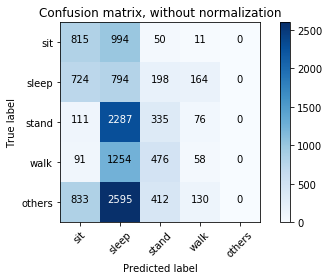

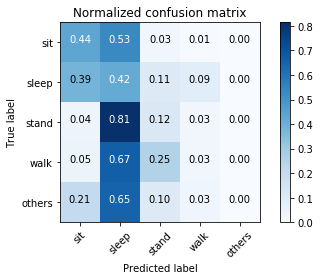

              precision    recall  f1-score   support

         sit       0.32      0.44      0.37      1870
       sleep       0.10      0.42      0.16      1880
       stand       0.23      0.12      0.16      2809
        walk       0.13      0.03      0.05      1879
      others       0.00      0.00      0.00      3970

   micro avg       0.16      0.16      0.16     12408
   macro avg       0.16      0.20      0.15     12408
weighted avg       0.13      0.16      0.12     12408



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
'''
other_list = ['sit','sleep','stand','walk','others']

df_all = pd.DataFrame()
y_true_all = []
y_pred_all = []

for subject_id in all_patients:
    print("Loading {0}'s data".format(subject_id))

    df_timer = load_timer(subject_id)

    start_time = df_timer.loc[0, 'time_start']
    end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

    df_acc = load_acc(subject_id, start_time, end_time)

    X_impure, y_impure = preprocess_data(df_acc)
    y_pred = predict_combine(X_impure, model)

    df_acc_label, df2, true_periods = group_dataframe_by_label(df_acc, df_timer, subject_id, label_list)

    df_all = df_all.append(df2, ignore_index=True)    # append to df_all

    y_true_others = get_others_from_true_periods(true_periods, df_acc.shape[0], label_list)
    true_periods_new = get_periods_from_list(y_true_others, other_list)

    p_periods = get_periods_from_list(y_pred, label_list)
    pred_periods = {}

    for i in range(len(label_list)):
        pred_periods[label_list[i]] = p_periods[i]

    y_true, df2 = get_y_true(df2)

    y_true_all.append(y_true)
    y_pred_all.append(y_pred)

print(df_all.shape)

y_true_all = np.hstack(y_true_all)
y_pred_all = np.hstack(y_pred_all)

print(y_true_all.shape, y_pred_all.shape)

evaluate_f1(y_true_all, y_pred_all, other_list)
'''